# Detección de ataques en red

## Conjunto de datos

### Descripción
NSL-KDD is a data set suggested to solve some of the inherent problems of the KDD'99 data set which are mentioned in. Although, this new version of the KDD data set still suffers from some of the problems discussed by McHugh and may not be a perfect representative of existing real networks, because of the lack of public data sets for network-based IDSs, we believe it still can be applied as an effective benchmark data set to help researchers compare different intrusion detection methods. Furthermore, the number of records in the NSL-KDD train and test sets are reasonable. This advantage makes it affordable to run the experiments on the complete set without the need to randomly select a small portion. Consequently, evaluation results of different research work will be consistent and comparable.

### Ficheros de datos
* <span style="color:green">**KDDTrain+.ARFF**: The full NSL-KDD train set with binary labels in ARFF format</span>
* KDDTrain+.TXT: The full NSL-KDD train set including attack-type labels and difficulty level in CSV format
* KDDTrain+_20Percent.ARFF:	A 20% subset of the KDDTrain+.arff file
* KDDTrain+_20Percent.TXT:	A 20% subset of the KDDTrain+.txt file
* KDDTest+.ARFF:	The full NSL-KDD test set with binary labels in ARFF format
* KDDTest+.TXT:	The full NSL-KDD test set including attack-type labels and difficulty level in CSV format
* KDDTest-21.ARFF:	A subset of the KDDTest+.arff file which does not include records with difficulty level of 21 out of 21
* KDDTest-21.TXT:	A subset of the KDDTest+.txt file which does not include records with difficulty level of 21 out of 21

### Descarga de los ficheros de datos
https://iscxdownloads.cs.unb.ca/iscxdownloads/NSL-KDD/#NSL-KDD

#### Referencias adicionales sobre el conjunto de datos
_M. Tavallaee, E. Bagheri, W. Lu, and A. Ghorbani, “A Detailed Analysis of the KDD CUP 99 Data Set,” Submitted to Second IEEE Symposium on Computational Intelligence for Security and Defense Applications (CISDA), 2009._

## Imports

In [1]:
import arff
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import (
    confusion_matrix, plot_confusion_matrix, accuracy_score,
    precision_score, recall_score, f1_score, plot_roc_curve,
    plot_precision_recall_curve
)

## Funciones auxiliares

In [2]:
def load_kdd_dataset(data_path):
    """Lectura del conjunto de datos NSL-KDD."""
    with open(data_path, 'r') as train_set:
        dataset = arff.load(train_set)
    attributes = [attr[0] for attr in dataset["attributes"]]
    return pd.DataFrame(dataset["data"], columns=attributes)

In [3]:
def train_val_test_split(df, rstate=42, shuffle=True, stratify=None):
    strat = df[stratify] if stratify else None
    train_set, test_set = train_test_split(
        df, test_size=0.4, random_state=rstate, shuffle=shuffle, stratify=strat)
    strat = test_set[stratify] if stratify else None
    val_set, test_set = train_test_split(
        test_set, test_size=0.5, random_state=rstate, shuffle=shuffle, stratify=strat)
    return (train_set, val_set, test_set)

In [4]:
def metrics(model, df_validation_input, df_validation_target, df_prediction):
    print("Matriz de confusión\n", confusion_matrix(df_validation_target, df_prediction))
    print("Accuracy:", accuracy_score(df_validation_target, df_prediction))
    print("Precisión:", precision_score(df_validation_target, df_prediction, pos_label="anomaly"))
    print("Recall:", recall_score(df_validation_target, df_prediction, pos_label="anomaly"))
    print("F1 score:", f1_score(df_validation_target, df_prediction, pos_label="anomaly"))
    plot_confusion_matrix(model, df_validation_input, df_validation_target, values_format="3g")

In [5]:
# Construcción de un pipeline para los atributos numéricos
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('rbst_scaler', RobustScaler()),
    ])

In [6]:
# Transormador para codificar únicamente las columnas categoricas y devolver un df
class CustomOneHotEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self._oh = OneHotEncoder(sparse=False)
        self._columns = None
    def fit(self, X, y=None):
        X_cat = X.select_dtypes(include=['object'])
        self._columns = pd.get_dummies(X_cat).columns
        self._oh.fit(X_cat)
        return self
    def transform(self, X, y=None):
        X_copy = X.copy()
        X_cat = X_copy.select_dtypes(include=['object'])
        X_num = X_copy.select_dtypes(exclude=['object'])
        X_cat_oh = self._oh.transform(X_cat)
        X_cat_oh = pd.DataFrame(X_cat_oh, 
                                columns=self._columns, 
                                index=X_copy.index)
        X_copy.drop(list(X_cat), axis=1, inplace=True)
        return X_copy.join(X_cat_oh)

In [7]:
# Transofrmador que prepara todo el conjunto de datos llamando pipelines y transformadores personalizados
class DataFramePreparer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self._full_pipeline = None
        self._columns = None
    def fit(self, X, y=None):
        num_attribs = list(X.select_dtypes(exclude=['object']))
        cat_attribs = list(X.select_dtypes(include=['object']))
        self._full_pipeline = ColumnTransformer([
                ("num", num_pipeline, num_attribs),
                ("cat", CustomOneHotEncoder(), cat_attribs),
        ])
        self._full_pipeline.fit(X)
        self._columns = pd.get_dummies(X).columns
        return self
    def transform(self, X, y=None):
        X_copy = X.copy()
        X_prep = self._full_pipeline.transform(X_copy)
        return pd.DataFrame(X_prep, 
                            columns=self._columns, 
                            index=X_copy.index)

## Lectura del conjunto de datos

In [8]:
df = load_kdd_dataset("datasets/NSL-KDD/KDDTrain+.arff")
df.head(10)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0.0,tcp,ftp_data,SF,491.0,0.0,0,0.0,0.0,0.0,...,25.0,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0.0,udp,other,SF,146.0,0.0,0,0.0,0.0,0.0,...,1.0,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0.0,tcp,private,S0,0.0,0.0,0,0.0,0.0,0.0,...,26.0,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
3,0.0,tcp,http,SF,232.0,8153.0,0,0.0,0.0,0.0,...,255.0,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0.0,tcp,http,SF,199.0,420.0,0,0.0,0.0,0.0,...,255.0,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal
5,0.0,tcp,private,REJ,0.0,0.0,0,0.0,0.0,0.0,...,19.0,0.07,0.07,0.00,0.00,0.00,0.00,1.00,1.00,anomaly
6,0.0,tcp,private,S0,0.0,0.0,0,0.0,0.0,0.0,...,9.0,0.04,0.05,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
7,0.0,tcp,private,S0,0.0,0.0,0,0.0,0.0,0.0,...,15.0,0.06,0.07,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
8,0.0,tcp,remote_job,S0,0.0,0.0,0,0.0,0.0,0.0,...,23.0,0.09,0.05,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
9,0.0,tcp,private,S0,0.0,0.0,0,0.0,0.0,0.0,...,13.0,0.05,0.06,0.00,0.00,1.00,1.00,0.00,0.00,anomaly


## División del conjunto de datos

In [9]:
# Division del conjunto en los diferentes subconjuntos
train_set, val_set, test_set = train_val_test_split(df)

print("Longitud del Training Set:", len(train_set))
print("Longitud del Validation Set:", len(val_set))
print("Longitud del Test Set:", len(test_set))

Longitud del Training Set: 75583
Longitud del Validation Set: 25195
Longitud del Test Set: 25195


Para cada uno de los subconjuntos, separamos las etiquetas de las características de entrada.

In [10]:
# Conjunto de datos general
x_df = df.drop("class", axis=1)
y_df = df["class"].copy()

# Conjunto de datos de entrenamiento
x_train = train_set.drop("class", axis=1)
y_train = train_set["class"].copy()

# Conjunto de datos de validación
x_validation = val_set.drop("class", axis=1)
y_validation = val_set["class"].copy()

# Conjunto de datos de pruebas
x_test = test_set.drop("class", axis=1)
y_test = test_set["class"].copy()

## Preparación del conjunto de datos

In [11]:
# Instanciamos nuestro transformador personalizado
data_preparer = DataFramePreparer()
# Hacemos el fit con el conjunto de datos general para que adquiera todos los valores posibles
data_preparer.fit(x_df)

# Transformamos el subconjunto de datos de entrenamiento
x_train_prep = data_preparer.transform(x_train)

# Transformamos el subconjunto de datos de validacion
x_val_prep = data_preparer.transform(x_validation)

# Transformamos el subconjunto de datos de prueba
x_test_prep = data_preparer.transform(x_test)

In [12]:
x_train

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
98320,0.0,icmp,ecr_i,SF,1032.0,0.0,0,0.0,0.0,0.0,...,210.0,65.0,0.31,0.01,0.31,0.00,0.0,0.0,0.0,0.0
8590,0.0,tcp,smtp,SF,1762.0,331.0,0,0.0,0.0,0.0,...,30.0,122.0,0.73,0.07,0.03,0.02,0.0,0.0,0.0,0.0
91385,0.0,icmp,eco_i,SF,8.0,0.0,0,0.0,0.0,0.0,...,2.0,126.0,1.00,0.00,1.00,0.25,0.0,0.0,0.0,0.0
54349,0.0,tcp,csnet_ns,S0,0.0,0.0,0,0.0,0.0,0.0,...,255.0,18.0,0.07,0.07,0.00,0.00,1.0,1.0,0.0,0.0
69568,0.0,tcp,smtp,SF,1518.0,342.0,0,0.0,0.0,0.0,...,83.0,125.0,0.66,0.05,0.01,0.02,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119879,0.0,tcp,echo,RSTO,0.0,0.0,0,0.0,0.0,0.0,...,255.0,4.0,0.02,0.09,0.00,0.00,0.0,0.0,1.0,1.0
103694,0.0,tcp,telnet,S0,0.0,0.0,0,0.0,0.0,0.0,...,255.0,4.0,0.02,0.07,0.01,0.00,1.0,1.0,0.0,0.0
860,0.0,tcp,http,REJ,0.0,0.0,0,0.0,0.0,0.0,...,255.0,6.0,0.02,0.07,0.00,0.00,0.0,0.0,1.0,1.0
15795,0.0,tcp,http,SF,309.0,4281.0,0,0.0,0.0,0.0,...,21.0,255.0,1.00,0.00,0.05,0.05,0.0,0.0,0.0,0.0


In [13]:
x_train_prep

,duration,src_bytes,dst_bytes,wrong_fragment,urgent,hot,num_failed_logins,num_compromised,root_shell,su_attempted,...,flag_SF,flag_SH,land_0,land_1,logged_in_0,logged_in_1,is_host_login_0,is_host_login_1,is_guest_login_0,is_guest_login_1
98320,0.0,3.579710,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
8590,0.0,6.224638,0.641473,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
91385,0.0,-0.130435,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
54349,0.0,-0.159420,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
69568,0.0,5.340580,0.662791,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119879,0.0,-0.159420,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
103694,0.0,-0.159420,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
860,0.0,-0.159420,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
15795,0.0,0.960145,8.296512,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0


In [14]:
x_validation

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
115297,0.0,tcp,uucp,S0,0.0,0.0,0,0.0,0.0,0.0,...,255.0,15.0,0.06,0.05,0.00,0.00,1.0,1.0,0.0,0.0
7438,0.0,tcp,http,SF,318.0,3016.0,0,0.0,0.0,0.0,...,255.0,255.0,1.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0
52597,5.0,tcp,smtp,SF,2274.0,334.0,0,0.0,0.0,0.0,...,104.0,52.0,0.50,0.05,0.01,0.00,0.0,0.0,0.0,0.0
10161,0.0,tcp,http,SF,292.0,1646.0,0,0.0,0.0,0.0,...,148.0,255.0,1.00,0.00,0.01,0.02,0.0,0.0,0.0,0.0
120044,0.0,tcp,finger,S0,0.0,0.0,0,0.0,0.0,0.0,...,255.0,72.0,0.28,0.02,0.01,0.00,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68314,0.0,tcp,http,SF,278.0,11251.0,0,0.0,0.0,0.0,...,7.0,255.0,1.00,0.00,0.14,0.06,0.0,0.0,0.0,0.0
35941,0.0,tcp,http,SF,347.0,49480.0,0,0.0,0.0,0.0,...,78.0,255.0,1.00,0.00,0.01,0.05,0.0,0.0,0.0,0.0
33416,0.0,icmp,ecr_i,SF,1032.0,0.0,0,0.0,0.0,0.0,...,255.0,177.0,0.69,0.02,0.69,0.00,0.0,0.0,0.0,0.0
72515,0.0,tcp,private,REJ,0.0,0.0,0,0.0,0.0,0.0,...,89.0,11.0,0.12,0.09,0.01,0.00,0.0,0.0,1.0,1.0


In [15]:
x_val_prep

,duration,src_bytes,dst_bytes,wrong_fragment,urgent,hot,num_failed_logins,num_compromised,root_shell,su_attempted,...,flag_SF,flag_SH,land_0,land_1,logged_in_0,logged_in_1,is_host_login_0,is_host_login_1,is_guest_login_0,is_guest_login_1
115297,0.0,-0.159420,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
7438,0.0,0.992754,5.844961,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
52597,5.0,8.079710,0.647287,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
10161,0.0,0.898551,3.189922,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
120044,0.0,-0.159420,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68314,0.0,0.847826,21.804264,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
35941,0.0,1.097826,95.891473,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
33416,0.0,3.579710,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
72515,0.0,-0.159420,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


## Entrenamiento de un algoritmo de Regresión Logística

In [16]:
# Entrenamos un algoritmo basado en regresión logística
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=2000, penalty="l2", tol=1e-4, solver="lbfgs", n_jobs=-1)
lr.fit(x_train_prep, y_train)

yLr_prediction_val = lr.predict(x_val_prep)
yLr_prediction_test = lr.predict(x_test_prep)

Evaluación sobre datos de validación:
Matriz de confusión
 [[11440   434]
 [  360 12961]]
Accuracy: 0.9684858106767216
Precisión: 0.9694915254237289
Recall: 0.9634495536466229
F1 score: 0.9664610965616288


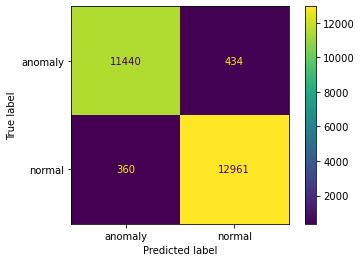

In [17]:
print("Evaluación sobre datos de validación:")
metrics(
    model=lr,
    df_validation_input=x_val_prep,
    df_validation_target=y_validation,
    df_prediction=yLr_prediction_val
)

Evaluación sobre datos de test:
Matriz de confusión
 [[11271   452]
 [  390 13082]]
Accuracy: 0.9665806707680096
Precisión: 0.9665551839464883
Recall: 0.9614433165571953
F1 score: 0.9639924734861445


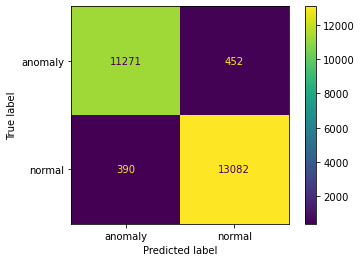

In [18]:
print("Evaluación sobre datos de test:")
metrics(
    model=lr,
    df_validation_input=x_test_prep,
    df_validation_target=y_test,
    df_prediction=yLr_prediction_test
)

#### Curva ROC

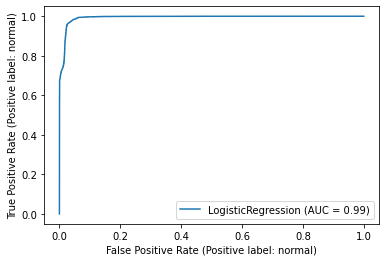

In [19]:
plot_roc_curve(lr, x_val_prep, y_validation)

#### Curva PR

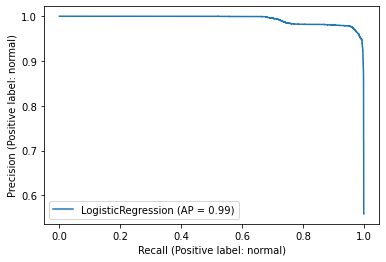

In [20]:
plot_precision_recall_curve(lr, x_val_prep, y_validation)

## Entrenamiento de un algoritmo de Árboles de Decisión

In [21]:
# Árboles de decisión
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier(criterion="gini", splitter="best", max_depth=20, random_state=50)
dtc.fit(x_train_prep, y_train)

yTree_prediction_val = dtc.predict(x_val_prep)
yTree_prediction_test = dtc.predict(x_test_prep)

Evaluación sobre datos de validación:
Matriz de confusión
 [[11846    28]
 [   18 13303]]
Accuracy: 0.9981742409208176
Precisión: 0.9984828051247472
Recall: 0.9976419066868789
F1 score: 0.9980621787850704


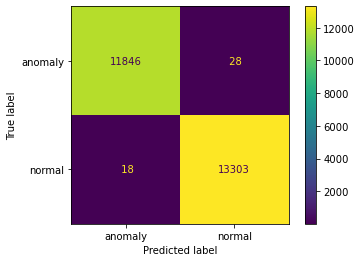

In [22]:
print("Evaluación sobre datos de validación:")
metrics(
    model=dtc,
    df_validation_input=x_val_prep,
    df_validation_target=y_validation,
    df_prediction=yTree_prediction_val
)

Evaluación sobre datos de test:
Matriz de confusión
 [[11702    21]
 [   22 13450]]
Accuracy: 0.9982933121651121
Precisión: 0.9981235073353805
Recall: 0.9982086496630556
F1 score: 0.9981660766835844


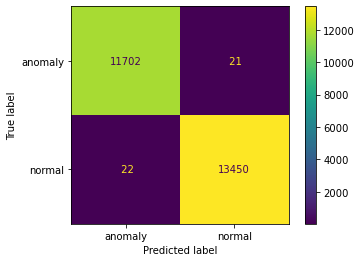

In [23]:
print("Evaluación sobre datos de test:")
metrics(
    model=dtc,
    df_validation_input=x_test_prep,
    df_validation_target=y_test,
    df_prediction=yTree_prediction_test
)

## Entrenamiento de un algoritmo Random Forest

In [24]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=100, criterion="gini", max_depth=20, random_state=50, n_jobs=-1)
rfc.fit(x_train_prep, y_train)

yForest_prediction_val = rfc.predict(x_val_prep)
yForest_prediction_test = rfc.predict(x_test_prep)

Evaluación sobre datos de validación:
Matriz de confusión
 [[11847    27]
 [    4 13317]]
Accuracy: 0.9987695971422902
Precisión: 0.9996624757404439
Recall: 0.9977261243052047
F1 score: 0.9986933614330874


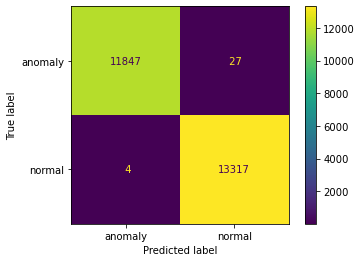

In [25]:
print("Evaluación sobre datos de validación:")
metrics(
    model=rfc,
    df_validation_input=x_val_prep,
    df_validation_target=y_validation,
    df_prediction=yForest_prediction_val
)

Evaluación sobre datos de test:
Matriz de confusión
 [[11703    20]
 [    6 13466]]
Accuracy: 0.9989680492161143
Precisión: 0.9994875736612862
Recall: 0.9982939520600529
F1 score: 0.9988904062820074


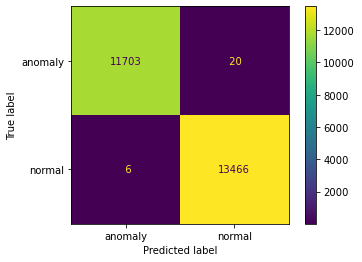

In [26]:
print("Evaluación sobre datos de test:")
metrics(
    model=rfc,
    df_validation_input=x_test_prep,
    df_validation_target=y_test,
    df_prediction=yForest_prediction_test
)

## Conclusión

Todos los modelos obtienen buenos resultados. Los valores de la diagonal principal de la matriz de confusión corresponden con los valores estimados de forma correcta por el modelo (verdaderos positivos y verdaderos negativos). Los valores de la diagonal contraria (falsos positivos y falsos negativos) tienen un ratio bastante bajo en comparación con las estimaciones correctas, haciendo que las métricas de exactitud, precisión y recall estén muy próxima a 1

Aún así podemos ver que el modelo con mejor desempeño es el `RandomForestClassifier`. 